In [17]:
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
input_names=["EUR_USD_Historical_Data_Train.csv"]
input_names_CV=["EUR_USD_Historical_Data_Validation.csv"]

windows=8
threshold=0.0
num_epoch=2000

In [3]:
def clean_data(input_names,output_names):
    with open(input_names, "r") as infile, open(output_names, "w") as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        conversion = set('"$%')
        for row in reader:
            newrow = [''.join('' if c in conversion else c for c in entry) for entry in row]
            writer.writerow(newrow)

In [4]:
def data_prepare_V1(input_names,windows,threshold):
    df = pd.read_csv(input_names, sep=',')
    test=int(windows/2)
    np_array=np.array(df)
    
    input_data=np.array([])
    input_data_raw=np.array([])
    data=np.zeros((int(np_array.shape[0]/windows)-windows,windows*4))
    output=np.zeros((int(np_array.shape[0]/windows)-windows,4))
    for i in range(int(np_array.shape[0]/windows)-windows):
        input_data=np.array([])
        
        for j in range(windows):
            input_data_raw=np_array[i*windows+j][1:5]
            input_data=np.concatenate((input_data,input_data_raw))

        #########################################
        #output shape:  [Hch%] Change percent   #
        #               [ C1 ]   Neutral        #
        #               [ C2 ]    Up            #
        #               [ C3 ]    Down          #
        #                                       #
        #########################################
        output[i,0]=np_array[i*windows+1][5]
        
        if output[i,0]>threshold:
            output[i,2]=1   # Up Trend
        elif output[i,0]<-threshold:
            output[i,3]=1   # Down Trend
        else:
            output[i,1]=1   # Neutral            
            
        output[i,1]=np.abs(output[i,1])    
            
        data[i,:]=input_data

    data=data.T
    output=output.T
      
    data_max=np.nanmax(data,axis=1,keepdims=True) 
    data_min=np.nanmin(data,axis=1,keepdims=True)  
    data=data/1
    data=-1+2*(data-data_min)/(data_max-data_min)

    output=output

    return data,output

In [5]:
def data_for_NN(input_names,windows,threshold):
    
    Exchange_NN=[]
    Indicators_NN=[]
    for string in input_names:
        
        output_names="Clean_"+string

        clean_data(input_names=string,output_names=output_names)
        data,output=data_prepare_V1(input_names=output_names,windows=windows,threshold=threshold)
        Exchange_NN.append(data)        

        Labels_NN=output        
    
    Exchange_NN=np.array(Exchange_NN)

    return Indicators_NN, Exchange_NN, Labels_NN

In [6]:
Indicators_NN, Exchange_NN, Labels_NN=data_for_NN(input_names=input_names,windows=windows,threshold=threshold)
Indicators_NN_CV, Exchange_NN_CV, Labels_NN_CV=data_for_NN(input_names=input_names_CV,windows=windows,threshold=threshold)

In [7]:
#Train Variables
Exchange_NN=np.reshape(Exchange_NN,(Exchange_NN.shape[1],Exchange_NN.shape[2]))
Labels_NN=Labels_NN

#Validation Varaibles
Exchange_NN_CV=np.reshape(Exchange_NN_CV,(Exchange_NN_CV.shape[1],Exchange_NN_CV.shape[2]))
Labels_NN_CV=Labels_NN_CV

#lables selection based on database
Labels_NN_NEW=Labels_NN[1:4,:]
Labels_NN_NEW_CV=Labels_NN_CV[1:4,:]

print("Exchange_NN shape is:",Exchange_NN.shape)
print("Labels_NN_NEW shape is:",Labels_NN_NEW.shape)

print("Exchange_NN_CV shape is:",Exchange_NN_CV.shape)
print("Labels_NN_NEW_CV shape is:",Labels_NN_NEW_CV.shape)

Exchange_NN shape is: (32, 617)
Labels_NN_NEW shape is: (3, 617)
Exchange_NN_CV shape is: (32, 155)
Labels_NN_NEW_CV shape is: (3, 155)


In [8]:
def forward_propagation(X,parameters):

    W1=parameters["W1"]
    b1=parameters["b1"]
    
    W2=parameters["W2"]
    b2=parameters["b2"]
    
    W3=parameters["W3"]
    b3=parameters["b3"]
 
    W4=parameters["W4"]
    b4=parameters["b4"]

    Z1=tf.add(tf.matmul(W1,X),b1)
    A1=tf.sigmoid(Z1)
    #A1=tf.nn.dropout(A1, 0.1,noise_shape=None, seed=None, name=None)
    
    Z2=tf.add(tf.matmul(W2,A1),b2)
    A2=tf.sigmoid(Z2)
    #A2=tf.nn.dropout(A2, 0.1,noise_shape=None, seed=None, name=None)
    
    Z3=tf.add(tf.matmul(W3,A2),b3)
    A3=tf.sigmoid(Z3)
    #A3=tf.nn.dropout(A3, 0.1,noise_shape=None, seed=None, name=None)
    
    Z4=tf.add(tf.matmul(W4,A3),b4)
    A4=tf.nn.sigmoid(Z4)
    #A4=tf.nn.dropout(A4, 0.1,noise_shape=None, seed=None, name=None)

    return Z4 , A4

In [9]:
def create_placeholders():     

    X=tf.keras.backend.placeholder(dtype=tf.float32, shape=(Exchange_NN.shape[0],Exchange_NN.shape[1]), name="X")
    Y=tf.keras.backend.placeholder(dtype=tf.float32, shape=(3,Exchange_NN.shape[1]), name="Y")
    
    X_CV=tf.keras.backend.placeholder(dtype=tf.float32, shape=(Exchange_NN_CV.shape[0],Exchange_NN_CV.shape[1]), name="X_CV")
    Y_CV=tf.keras.backend.placeholder(dtype=tf.float32, shape=(3,Exchange_NN_CV.shape[1]), name="Y_CV")

    return X,Y,X_CV,Y_CV

In [10]:
def initialize_parameters():
  
  with tf.compat.v1.variable_scope("initialize_parameters",reuse=tf.compat.v1.AUTO_REUSE):    
    
    W1=tf.compat.v1.get_variable(name="W1",trainable=True, shape=[10,Exchange_NN.shape[0]], dtype=tf.float32, initializer=tf.keras.initializers.GlorotNormal(),regularizer=tf.keras.regularizers.l2(0.01))
    b1=tf.compat.v1.get_variable(name="b1",trainable=True, shape=[10,1], dtype=tf.float32, initializer=tf.zeros_initializer(),regularizer=None)
       
    W2=tf.compat.v1.get_variable(name="W2",trainable=True, shape=[6,10], dtype=tf.float32, initializer=tf.keras.initializers.GlorotNormal(),regularizer=tf.keras.regularizers.l2(0.01))
    b2=tf.compat.v1.get_variable(name="b2",trainable=True, shape=[6,1], dtype=tf.float32, initializer=tf.zeros_initializer(),regularizer=None)

    W3=tf.compat.v1.get_variable(name="W3",trainable=True, shape=[4,6], dtype=tf.float32, initializer=tf.keras.initializers.GlorotNormal(),regularizer=tf.keras.regularizers.l2(0.01))
    b3=tf.compat.v1.get_variable(name="b3",trainable=True, shape=[4,1], dtype=tf.float32, initializer=tf.zeros_initializer(),regularizer=None)
    
    W4=tf.compat.v1.get_variable(name="W4",trainable=True, shape=[3,4], dtype=tf.float32, initializer=tf.keras.initializers.GlorotNormal(),regularizer=tf.keras.regularizers.l2(0.01))
    b4=tf.compat.v1.get_variable(name="b4",trainable=True, shape=[3,1], dtype=tf.float32, initializer=tf.zeros_initializer(),regularizer=None)
    
    parameters={
        "W1":W1,
        "W2":W2,
        "W3":W3,
        "W4":W4,
        "b1":b1,
        "b2":b2,
        "b3":b3,
        "b4":b4
                }
  return parameters

In [11]:
def compute_cost(Z4,Y):
   
    logits = tf.transpose(Z4)
    labels = tf.transpose(Y)
    
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits))
    return cost

In [12]:
def predict_accuracy(Z4,Y):

    correct_Z4 = tf.argmax(Z4)
    correct_Y= tf.argmax(Y)
    
    return correct_Z4,correct_Y    

In [13]:
def Compute_FScore(Target,Predicted):
    
    Target_Label=Label_FScore(Values=Target)
    Predicted_Label=Label_FScore(Values=Predicted)
    metric=metrics.classification_report(Target_Label, Predicted_Label, digits=3)
            
    return  metric

In [14]:
def Label_FScore(Values):
    
    data_size=Values.shape[1]
    Result=np.zeros((Values.shape[1]))
           
    for i in range(data_size):
        if int(np.sum(np.multiply(Values[:,i],[0,0,1])))==1:      
            Result[i]=1  #"Down"
        elif int(np.sum(np.multiply(Values[:,i],[0,1,0])))==1:     
            Result[i]=2  #"Up"
        else:
            Result[i]=3  #"Neutral"                                
    return Result    

In [15]:
def model(train_x,train_y,learning_rate=0.001,num_epoch=150):
    
    costs = []

    tf.compat.v1.disable_v2_behavior()

    X,Y,X_CV,Y_CV=create_placeholders()
    
    parameters=initialize_parameters()  
    
    Z4,A4=forward_propagation(X,parameters)
        
    cost=compute_cost(Z4,Y)  
    
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False,
    name='Adam').minimize(cost)
    
    init = tf.compat.v1.global_variables_initializer() 
    
    epoch_count=[]
    cost_count=[]
    cost_CV_count=[]
    
    with tf.compat.v1.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(1,num_epoch):
            
            epoch_cost=0
        
            _ , epoch_cost=sess.run([optimizer,cost],feed_dict={X:Exchange_NN, Y:Labels_NN_NEW})
        
            if  epoch % 200 == 0:
                        
                print ("   Cost after epoch %i: %f" % (epoch, epoch_cost))
                cost_count.append(epoch_cost)
                
                Z4_CV,A4_CV=forward_propagation(X_CV,parameters)
                cost_CV=compute_cost(Z4_CV,Y_CV)
                result_CV=cost_CV.eval(feed_dict={X_CV: Exchange_NN_CV, Y_CV: Labels_NN_NEW_CV})
                cost_CV_count.append(result_CV)
                print ("CV Cost after epoch %i: %f" % (epoch, result_CV))
        
        plt.plot(cost_count,'r',cost_CV_count,'b')
        
        parameters = sess.run(parameters)    
    
        correct_Z4,correct_Y=predict_accuracy(Z4,Y)
        train_result=correct_Z4.eval(feed_dict={X: Exchange_NN, Y: Labels_NN_NEW})
        set_result=correct_Y.eval(feed_dict={X: Exchange_NN, Y: Labels_NN_NEW})    
        
        Z4_CV,A4_CV=forward_propagation(X_CV,parameters)
        
        correct_Z4_CV,correct_Y_CV=predict_accuracy(A4_CV,Y_CV)
        train_result_CV=correct_Z4_CV.eval(feed_dict={X_CV: Exchange_NN_CV, Y_CV: Labels_NN_NEW_CV})
        set_result_CV=correct_Y_CV.eval(feed_dict={X_CV: Exchange_NN_CV, Y_CV: Labels_NN_NEW_CV})

        train_accuracy=(1-(np.sum(np.abs(train_result-set_result)/2)/set_result.shape[0]))*100
        CV_accuracy=(1-(np.sum(np.abs(train_result_CV-set_result_CV)/2)/set_result_CV.shape[0]))*100
        
        print("Train  accuracy :",int(train_accuracy),"%")
        print("CV accuracy is",int(CV_accuracy),"%")
        print("Validation accuracy table :")
        
        Final_Eval=A4_CV.eval(feed_dict={X_CV: Exchange_NN_CV, Y_CV: Labels_NN_NEW_CV})
        
        ##### F1-Score Calculation
        Max_Prob=np.amax(Final_Eval, axis=0)
        Final_Eval_CV=1*(Final_Eval>=Max_Prob)
        print(Compute_FScore(Target=Labels_NN_NEW_CV,Predicted=Final_Eval_CV))
        #####

        return set_result,train_result,set_result_CV,train_result_CV,Final_Eval    

Instructions for updating:
non-resource variables are not supported in the long term
   Cost after epoch 200: 0.819191
CV Cost after epoch 200: 0.802984
   Cost after epoch 400: 0.772129
CV Cost after epoch 400: 0.750830
   Cost after epoch 600: 0.761613
CV Cost after epoch 600: 0.736686
   Cost after epoch 800: 0.758847
CV Cost after epoch 800: 0.731626
   Cost after epoch 1000: 0.758016
CV Cost after epoch 1000: 0.729476
   Cost after epoch 1200: 0.757453
CV Cost after epoch 1200: 0.728092
   Cost after epoch 1400: 0.755212
CV Cost after epoch 1400: 0.723612
   Cost after epoch 1600: 0.714586
CV Cost after epoch 1600: 0.635653
   Cost after epoch 1800: 0.576815
CV Cost after epoch 1800: 0.456831
Train dataset accuracy is 89 %
Validation accuracy detailed table:
              precision    recall  f1-score   support

         1.0      0.758     0.958     0.847        72
         2.0      0.953     0.744     0.836        82
         3.0      0.000     0.000     0.000         1

    accu

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


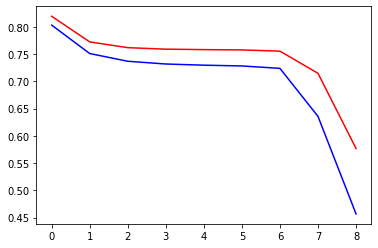

In [16]:
set_result,train_result,set_result_CV,train_result_CV,Final_Eval=model(train_x=Exchange_NN,train_y=Labels_NN_NEW,learning_rate=0.001,num_epoch=num_epoch)
tf.compat.v1.get_variable_scope().reuse_variables()    

In [46]:
AUD_EUR=[0.81	,0.82,	0.94,	0.95,	0.75,	0.76,	0.86,	0.86,	0.71,	0.72,	0.81,	0.82,	0.86,	0.87,	0.80,	0.80,	0.78,	0.80,	0.51,	0.60,	0.70,	0.72,	0.74,	0.75,	0.88,	0.90,	0.77,	0.78,	0.75,	0.77,	0.82,	0.83]
AUD_EUR_F1=AUD_EUR[0:32:2]
print(AUD_EUR_F1)
AUD_EUR_ACC=AUD_EUR[1:32:2]
print(AUD_EUR_ACC)

AUD_USD=[0.82,	0.82,	0.68,	0.70,	0.79,	0.80,	0.68,	0.71,	0.85,	0.86,	0.86,	0.87,	0.89,	0.90,	0.78,	0.79,	0.91,	0.91,	0.83,	0.83,	0.87,	0.87,	0.82,	0.82,	0.79,	0.80,	0.80,	0.81,	0.80,	0.81,	0.80,	0.80]
AUD_USD_F1=AUD_USD[0:32:2]
print(AUD_USD_F1)
AUD_USD_ACC=AUD_USD[1:32:2]
print(AUD_USD_ACC)

EUR_USD=[0.80,	0.80,	0.75,	0.76,	0.77,	0.77,	0.94,	0.95,	0.78,	0.79,	0.68,	0.71,	0.83,	0.83,	0.81,	0.81,	0.81,	0.81,	0.66,	0.70,	0.66,	0.67,	0.93,	0.94,	0.89,	0.90,	0.76,	0.77,	0.73,	0.74,	0.60,	0.62]
EUR_USD_F1=EUR_USD[0:32:2]
print(EUR_USD_F1)
EUR_USD_ACC=EUR_USD[1:32:2]
print(EUR_USD_ACC)

GBP_JPY=[0.90,	0.90,	0.81,	0.81,	0.81,	0.82,	0.89,	0.90,	0.86,	0.86,	0.84,	0.85,	0.81,	0.82,	0.83,	0.84,	0.82,	0.82,	0.82,	0.81,	0.85,	0.85,	0.89,	0.89,	0.89,	0.89,	0.87,	0.87,	0.87,	0.87,	0.81,	0.82]
GBP_JPY_F1=GBP_JPY[0:32:2]
print(GBP_JPY_F1)
GBP_JPY_ACC=GBP_JPY[1:32:2]
print(GBP_JPY_ACC)

USD_CAD=[0.85,	0.85,	0.80,	0.81,	0.79,	0.80,	0.79,	0.81,	0.80,	0.81,	0.83,	0.84,	0.70,	0.71,	0.90,	0.90,	0.89,	0.90,	0.66,	0.69,	0.87,	0.88,	0.81,	0.81,	0.72,	0.73,	0.81,	0.82,	0.82,	0.83,	0.80,	0.82]
USD_CAD_F1=USD_CAD[0:32:2]
print(USD_CAD_F1)
USD_CAD_ACC=USD_CAD[1:32:2]
print(USD_CAD_ACC)

window=[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]



[0.81, 0.94, 0.75, 0.86, 0.71, 0.81, 0.86, 0.8, 0.78, 0.51, 0.7, 0.74, 0.88, 0.77, 0.75, 0.82]
[0.82, 0.95, 0.76, 0.86, 0.72, 0.82, 0.87, 0.8, 0.8, 0.6, 0.72, 0.75, 0.9, 0.78, 0.77, 0.83]
[0.82, 0.68, 0.79, 0.68, 0.85, 0.86, 0.89, 0.78, 0.91, 0.83, 0.87, 0.82, 0.79, 0.8, 0.8, 0.8]
[0.82, 0.7, 0.8, 0.71, 0.86, 0.87, 0.9, 0.79, 0.91, 0.83, 0.87, 0.82, 0.8, 0.81, 0.81, 0.8]
[0.8, 0.75, 0.77, 0.94, 0.78, 0.68, 0.83, 0.81, 0.81, 0.66, 0.66, 0.93, 0.89, 0.76, 0.73, 0.6]
[0.8, 0.76, 0.77, 0.95, 0.79, 0.71, 0.83, 0.81, 0.81, 0.7, 0.67, 0.94, 0.9, 0.77, 0.74, 0.62]
[0.9, 0.81, 0.81, 0.89, 0.86, 0.84, 0.81, 0.83, 0.82, 0.82, 0.85, 0.89, 0.89, 0.87, 0.87, 0.81]
[0.9, 0.81, 0.82, 0.9, 0.86, 0.85, 0.82, 0.84, 0.82, 0.81, 0.85, 0.89, 0.89, 0.87, 0.87, 0.82]
[0.85, 0.8, 0.79, 0.79, 0.8, 0.83, 0.7, 0.9, 0.89, 0.66, 0.87, 0.81, 0.72, 0.81, 0.82, 0.8]
[0.85, 0.81, 0.8, 0.81, 0.81, 0.84, 0.71, 0.9, 0.9, 0.69, 0.88, 0.81, 0.73, 0.82, 0.83, 0.82]


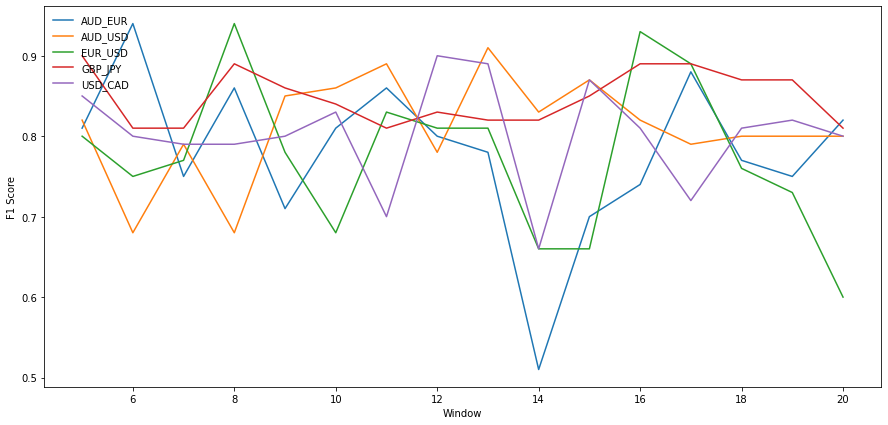

In [60]:
import matplotlib
plt.axis=([4,21,0,1])
plt.figure(figsize=(15, 7))
#matplotlib.axes.Axes.set_xlim(self,xmin=0, xmax=25)
plt.ylabel("F1 Score")
plt.xlabel("Window")
plt.plot(window,AUD_EUR_F1,label="AUD_EUR")
plt.plot(window,AUD_USD_F1,label="AUD_USD")
plt.plot(window,EUR_USD_F1,label="EUR_USD")
plt.plot(window,GBP_JPY_F1,label="GBP_JPY")
plt.plot(window,USD_CAD_F1,label="USD_CAD")

plt.legend(loc='upper left', frameon=False)
